In [2]:
import os
import glob
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm


In [2]:
class LinModel(nn.Module):
    def __init__(self):
        super(LinModel, self).__init__()
        self.lin1 = nn.Linear(1024*7*7, 4068)
        self.lin2 = nn.Linear(4068, 512)
        self.lin3 = nn.Linear(512, 8)

    def forward(self, x):
        x = self.lin1(x)
        x = self.lin2(x)
        x = self.lin3(x)
        return x

In [3]:
# lane_model = torch.load('saved_models/vgg16_pretained_2lane.pth',map_location='cuda:0')
# box_model = torch.load('saved_models/unet_pretrained_boxnet.pth',map_location='cuda:0')
lane_model = torch.load('saved_models/unet_plain_exp_3.pth',map_location='cuda:0')

/home/anudeep/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'models.Unet.UNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [4]:
data_dir = '/home/anudeep/lane-detection/dataset'
data = pd.read_json(os.path.join(data_dir, 'label_data.json'), lines=True)
data.info()
print(len(data.raw_file))
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2855 entries, 0 to 2854
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   lanes      2855 non-null   object
 1   h_samples  2855 non-null   object
 2   raw_file   2855 non-null   object
dtypes: object(3)
memory usage: 67.0+ KB
2855


,lanes,h_samples,raw_file
0,"[[-100, -100, -100, -100, 632, 625, 617, 609, ...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-1/6040/20.jpg
1,"[[-100, -100, -100, 658, 646, 635, 623, 612, 6...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-1/5320/20.jpg
2,"[[-100, 570, 554, 538, 522, 505, 489, 473, 456...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-1/23700/20.jpg
3,"[[-100, -100, -100, -100, 555, 542, 530, 517, ...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-1/51660/20.jpg
4,"[[-100, -100, -100, 522, 525, 528, 531, 534, 5...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-1/25680/20.jpg
...,...,...,...
2850,"[[-100, -100, -100, 595, 589, 583, 577, 571, 5...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-2/26520/20.jpg
2851,"[[-100, -100, 728, 683, 651, 624, 608, 592, 57...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-2/30960/20.jpg
2852,"[[417, 435, 453, 471, 477, 478, 480, 481, 482,...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-2/23220/20.jpg
2853,"[[-100, -100, -100, -100, 440, 451, 458, 458, ...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-2/35300/20.jpg


Reading from:  /home/anudeep/lane-detection/dataset/clips/0313-1/52260/20.jpg


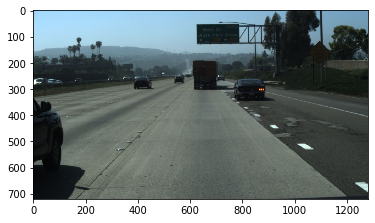

In [5]:
i=71
img_path = data.raw_file[i]
img_path = os.path.join(data_dir,img_path)
print('Reading from: ', img_path)
img_raw = cv2.imread(img_path)
img1 = cv2.cvtColor(img_raw,cv2.COLOR_BGR2RGB)
plt.imshow(img1)

In [6]:
# lane_model = lane_model.eval()

In [7]:
lane_model

UNet(
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (conv2): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [29]:
img2 = cv2.imread('test_images/test2.jpg') 
img2 = cv2.cvtColor(img_raw,cv2.COLOR_BGR2RGB)
img = cv2.resize(img2,(128,128), cv2.INTER_NEAREST)
img = np.transpose(img, (2, 0, 1))
img = np.expand_dims(img, axis=0)

In [30]:
pred = lane_model(torch.tensor(img).float().cuda())

In [13]:
p = prediction.numpy()
p = p*255
p = np.array(p, dtype= np.uint8)

In [14]:
ret, otsu = cv2.threshold(p,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

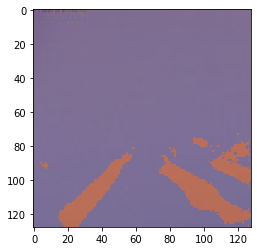

In [16]:
plt.imshow(img_raw)
plt.imshow(otsu, cmap='jet', alpha=0.5)

In [295]:
pts = np.array([ 93.0000,  98.0000, 104.3571, 106.0000, 115.7143, 108.0000, 127.0714,
         107.0000, 138.4286, 102.0000, 149.7857,  97.2143, 161.1429,  93.0000,
         172.5000,  88.0000, 183.8571,  84.0000, 195.2143,  79.0000, 206.5714,
          74.4286, 217.9286,  70.0714, 229.2857,  65.0000, 240.6429,  60.3571,
         252.0000,  56.0000,  89.0000, 103.0000, 100.4286, 124.8571, 111.8571,
         137.8571, 123.2857, 148.5714, 134.7143, 158.7143, 146.1429, 167.1429,
         157.5714, 176.0000, 169.0000, 185.0000, 180.4286, 193.4286, 191.8571,
         202.0000, 203.2857, 211.0000, 214.7143, 219.7143, 226.1429, 228.1429,
         237.5714, 237.5714, 249.0000, 246.0000])

In [296]:
pts2 = np.array([ 90.1448, 118.1871, 108.9609, 118.4615, 112.6932, 109.1907, 117.6675,
         108.2455, 135.4236,  89.1841, 140.6975,  87.3705, 157.4006,  85.6641,
         155.6452,  80.0036, 176.5171,  66.3670, 190.2907,  68.5969, 205.7040,
          56.6651, 202.5797,  54.5265, 209.9849,  49.5005, 234.2899,  43.3456,
         236.0405,  31.2421,  86.4972, 136.8933,  98.5520, 143.6005, 106.1858,
         142.6644, 120.2555, 146.1121, 128.2561, 163.6586, 137.0246, 165.8938,
         154.8114, 165.6002, 166.5494, 177.7306, 171.1558, 184.2314, 187.8522,
         190.8267, 194.9705, 199.4245, 207.8108, 210.3585, 211.7776, 212.8470,
         220.6301, 222.2526, 230.7956, 226.8179])

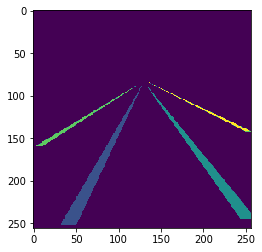

In [298]:
pts = pts.reshape((4,15))
pts2 = pts2.reshape((4,15))
plt.imshow(mask1)

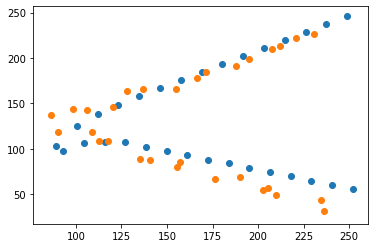

In [42]:
pts = pts.reshape((30,2))
pts2 = pts2.reshape((30,2))

x1 = []
y1 = []
x2 = []
y2 = []
for i,j in  pts:
    x1.append(i)
    y1.append(j)
for i,j in  pts2:
    x2.append(i)
    y2.append(j)
    
    
plt.scatter(x1,y1)
plt.scatter(x2,y2)

In [46]:
a1 = np.array([[1,2], [3,4]])
a2 = np.array([[5,6], [7,8]])
np.array(a1+a2)

array([[ 6,  8],
       [10, 12]])

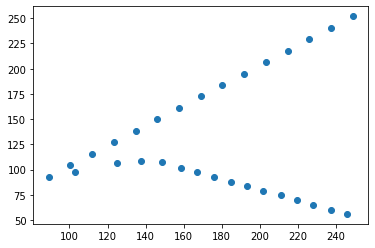

In [39]:
pts = pts.reshape((2,30))
plt.scatter(pts[1],pts[0])

In [54]:
def points_interpolation(x1, y1, num_points=15):
        x2 = np.unique(x1)
        y2 = []
        for i in x2: 
            tx = np.where(x1==i)[0] 
            ty = np.floor(np.min([tx[0],tx[-1]]) + np.absolute((tx[0]-tx[-1])/2)) 
            y2.append( y1[int(ty)] )

        xvals = np.linspace(x2[0], x2[-1], num_points)
        yvals = np.interp(xvals, x2, y2)
        return xvals, yvals

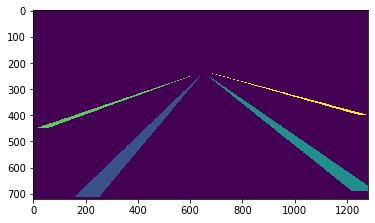

In [283]:
mask = plt.imread('datasets/tu_simple/masks/0313-1/10040/1.tiff')
plt.imshow(mask)

In [284]:
x1,y1 = np.where(mask==1)
x2,y2 = np.where(mask==2)

l1_x, l1_y = points_interpolation(y1, y1)
l2_x, l2_y = points_interpolation(x2, y2)

pts1 = [[i,j] for i, j in zip(l1_x, l1_y)] 
pts2 = [[i,j] for i, j in zip(l2_x, l2_y)]
pts = np.array(pts1 + pts2)
points = pts.reshape(-1)
print(points)

[ 160.          160.          194.28571429  254.71428571  228.57142857
  224.57142857  262.85714286  285.85714286  297.14285714  265.28571429
  331.42857143  359.42857143  365.71428571  351.42857143  400.
  397.          434.28571429  422.28571429  468.57142857  450.14285714
  502.85714286  513.          537.14285714  528.85714286  571.42857143
  571.71428571  605.71428571  603.42857143  640.          640.
  250.          668.          281.42857143  709.42857143  312.85714286
  752.71428571  344.28571429  795.28571429  375.71428571  838.42857143
  407.14285714  881.14285714  438.57142857  924.14285714  470.
  966.          501.42857143 1008.42857143  532.85714286 1051.71428571
  564.28571429 1093.57142857  595.71428571 1136.71428571  627.14285714
 1179.14285714  658.57142857 1222.14285714  690.         1249.        ]


[[ 160.          160.          194.28571429  254.71428571  228.57142857
   224.57142857  262.85714286  285.85714286  297.14285714  265.28571429
   331.42857143  359.42857143  365.71428571  351.42857143  400.        ]
 [ 397.          434.28571429  422.28571429  468.57142857  450.14285714
   502.85714286  513.          537.14285714  528.85714286  571.42857143
   571.71428571  605.71428571  603.42857143  640.          640.        ]
 [ 250.          668.          281.42857143  709.42857143  312.85714286
   752.71428571  344.28571429  795.28571429  375.71428571  838.42857143
   407.14285714  881.14285714  438.57142857  924.14285714  470.        ]
 [ 966.          501.42857143 1008.42857143  532.85714286 1051.71428571
   564.28571429 1093.57142857  595.71428571 1136.71428571  627.14285714
  1179.14285714  658.57142857 1222.14285714  690.         1249.        ]]


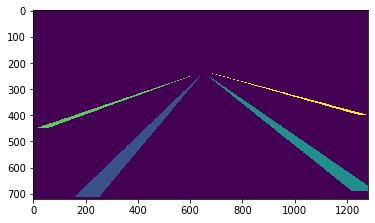

In [306]:
plt.imshow(mask)
points = points.reshape(4,15)
print(points)

In [285]:
def get_x(y, mask, l):
    xi = np.where(mask[y,:]==l)
    xi = xi[0]
#     xx = (xi[0]+xi[-1])/2
    if len(xi)>3:
        xx = np.median(xi)
    else:
        xx = get_x(y+2, mask, l)
    return xx

In [286]:
def get_pts_from_lane(idx, mask):
    x,y = np.where(mask==idx)
    y_vals = np.linspace(min(x),max(x),15)
    y_vals = np.array(y_vals).astype(np.int16)
    x_vals = [get_x(int(y), mask, idx) for y in y_vals]
    return x_vals, y_vals

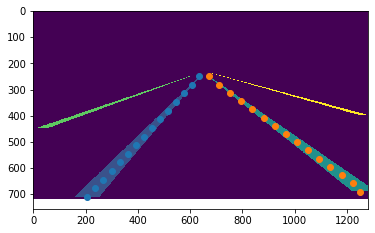

In [287]:
plt.imshow(mask)
x1, y1 = get_pts_from_lane(1,mask)
x2, y2 = get_pts_from_lane(2,mask)
plt.scatter(x1, y1)
plt.scatter(x2, y2)

In [288]:
def get_pts(mask):
    x1, y1 = get_pts_from_lane(1,mask)
    x2, y2 = get_pts_from_lane(2,mask)
    pts = np.array([x1,y1,x2,y2])
    return pts.reshape(-1)

In [289]:
pts = get_pts(mask)
print(pts)


[ 633.   609.   577.5  547.   516.   484.5  453.5  423.   393.   361.5
  331.   300.   268.5  237.5  207.   250.   282.   315.   348.   381.
  414.   447.   480.   512.   545.   578.   611.   644.   677.   710.
  670.5  709.5  751.5  795.5  837.5  881.   923.   966.  1008.5 1050.5
 1093.5 1136.  1179.  1221.  1249.5  250.   281.   312.   344.   375.
  407.   438.   470.   501.   532.   564.   595.   627.   658.   690. ]


In [290]:
a = np.arange(60)
a.reshape((4,15))
a.reshape(-1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59])

In [291]:
pts = pts.reshape((4,15))

x11 = pts[0]
y11 = pts[1]
x12 = pts[2]
y12 = pts[3]

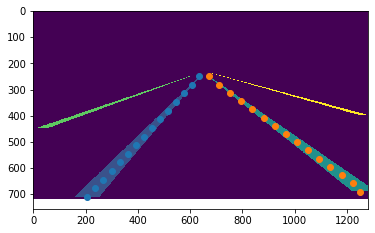

In [292]:
plt.imshow(mask)
plt.scatter(x11,y11)
plt.scatter(x12,y12)

[[125.  119.5 116.5 110.5 104.   97.   91.   85.   79.   72.5  67.   61.
   53.5  47.5  41. ]
 [ 86.   97.  109.  121.  133.  145.  157.  169.  180.  192.  204.  216.
  228.  240.  252. ]
 [145.  145.  150.  158.  166.5 175.  183.5 192.  200.5 209.  217.  226.5
  235.  243.  249.5]
 [ 87.   98.  109.  120.  132.  143.  154.  166.  177.  188.  199.  211.
  222.  233.  245. ]]


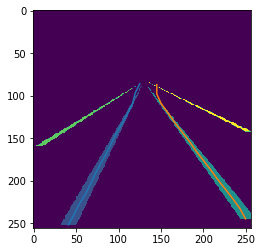

In [312]:
mask1 = cv2.resize(mask, (256,256), cv2.INTER_NEAREST)
pts = get_pts(mask1)
pts = pts.reshape((4,15))
print(pts)
x11 = pts[0]
y11 = pts[1]
x12 = pts[2]
y12 = pts[3]
plt.imshow(mask1)
plt.plot(x11,y11)
plt.plot(x12,y12)

In [310]:
pred_points = np.array([ 93.0000,  98.0000, 104.3571, 106.0000, 115.7143, 108.0000, 127.0714,
         107.0000, 138.4286, 102.0000, 149.7857,  97.2143, 161.1429,  93.0000,
         172.5000,  88.0000, 183.8571,  84.0000, 195.2143,  79.0000, 206.5714,
          74.4286, 217.9286,  70.0714, 229.2857,  65.0000, 240.6429,  60.3571,
         252.0000,  56.0000,  89.0000, 103.0000, 100.4286, 124.8571, 111.8571,
         137.8571, 123.2857, 148.5714, 134.7143, 158.7143, 146.1429, 167.1429,
         157.5714, 176.0000, 169.0000, 185.0000, 180.4286, 193.4286, 191.8571,
         202.0000, 203.2857, 211.0000, 214.7143, 219.7143, 226.1429, 228.1429,
         237.5714, 237.5714, 249.0000, 246.0000])

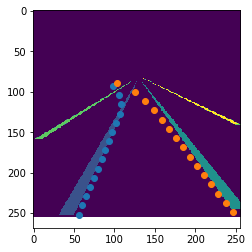

In [313]:
plt.imshow(mask1)
pred_points = pred_points.reshape(30,2)
plt.scatter(pred_points[:15,1], pred_points[:15,0])
plt.scatter(pred_points[15:,1], pred_points[15:,0])